# Evaluación

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [00:01<00:00, 411.41it/s]
/home/cristian/INFO343/INFO343_2023_3/tarea_final/train.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_data.append((torch.tensor(x_padded), y, audio))


Valor maximo: 134
Relleno: -20.55741310119629
594


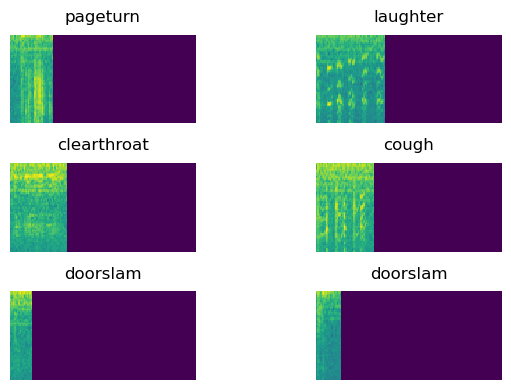

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import yaml
from matplotlib import pyplot as plt
from IPython.display import display, Audio
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from torch.utils.data import random_split, DataLoader
from train import featurizer_pipeline, remove_paths, padd
from model import MyConvModel
from dataset import data
from sklearn.metrics import classification_report

params = yaml.safe_load(open("params.yaml"))
pipeline = featurizer_pipeline(params["features"])
data = data('data_test', transforms=pipeline)
padd_data = padd(data, max_length=134, min_value=-20.55741310119629)
print(len(data))
seed = params['training']['dataset_split_seed']
_,_, test_set = random_split(padd_data, [0,0, 594],
                              generator=torch.Generator().manual_seed(seed))


fig, ax = plt.subplots(3, 2, figsize=(10, 4), tight_layout=True)
for (example, label, file_name), ax_ in zip(test_set, ax.ravel()):
    ax_.matshow(example.numpy()[0])
    ax_.axis('off')
    ax_.set_title(data.label_int2str([label])[0])
    display(Audio(filename=file_name))

In [42]:
test_loader = DataLoader(test_set, shuffle=False, batch_size=200, 
                         collate_fn=remove_paths)

## Modelo para Conjunto Aislado

In [43]:
clf = MyConvModel(params['training']).load_from_checkpoint('logs/lightning_logs/modelo_aislado/checkpoints/best_model.ckpt')
clf.eval()

MyConvModel(
  (criterion): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.5, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.5, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.5, inplace=False)
  )
  (c

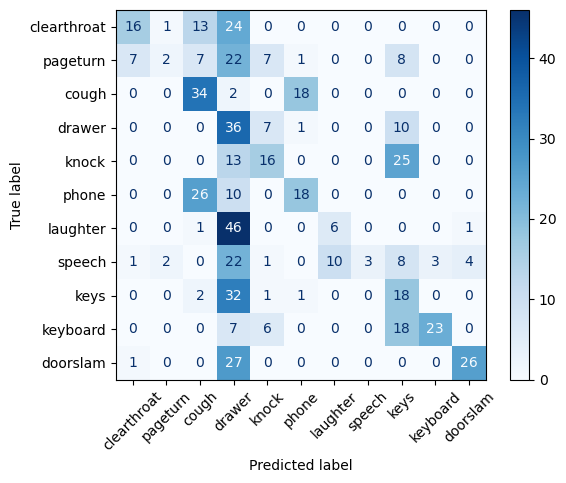

In [44]:
y_pred, y_true = [], []
for logmels, labels in test_loader:
    y_pred.append(clf(logmels).argmax(dim=1).detach().cpu().numpy())
    y_true.append(labels.detach().cpu().numpy())
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, 
                                        display_labels=data.categories, 
                                        xticks_rotation=45, cmap=plt.cm.Blues);

In [45]:
classification_rep = classification_report(y_true, y_pred, target_names=data.categories)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

 clearthroat       0.64      0.30      0.41        54
    pageturn       0.40      0.04      0.07        54
       cough       0.41      0.63      0.50        54
      drawer       0.15      0.67      0.24        54
       knock       0.42      0.30      0.35        54
       phone       0.46      0.33      0.39        54
    laughter       0.38      0.11      0.17        54
      speech       1.00      0.06      0.11        54
        keys       0.21      0.33      0.26        54
    keyboard       0.88      0.43      0.57        54
    doorslam       0.84      0.48      0.61        54

    accuracy                           0.33       594
   macro avg       0.53      0.33      0.33       594
weighted avg       0.53      0.33      0.33       594



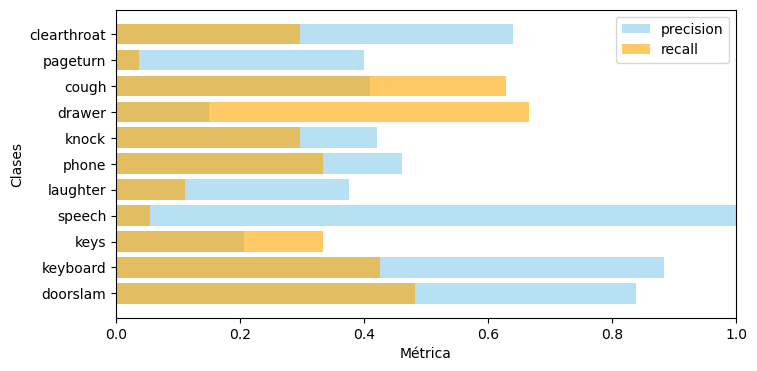

In [46]:
classification_rep = classification_report(y_true, y_pred, target_names=data.categories, output_dict=True)

precision_values = [classification_rep[label]['precision'] for label in classification_rep.keys() if label in data.categories]
recall_values = [classification_rep[label]['recall'] for label in classification_rep.keys() if label in data.categories]

class_labels = [label for label in classification_rep.keys() if label in data.categories]

plt.figure(figsize=(8, 4))
plt.barh(class_labels, precision_values, color='skyblue',label='precision',alpha =0.6)
plt.barh(class_labels, recall_values, color='orange',label='recall',alpha =0.6 )
plt.xlabel('Métrica')
plt.ylabel('Clases')

plt.xlim(0, 1) 
plt.gca().invert_yaxis()  
plt.legend()
plt.show()


## Modelo para Conjunto Mixto

In [77]:
clf = MyConvModel(params['training']).load_from_checkpoint('logs/lightning_logs/modelo_mixto/checkpoints/best_model.ckpt')
clf.eval()

MyConvModel(
  (criterion): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.5, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.5, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.5, inplace=False)
  )
  (c

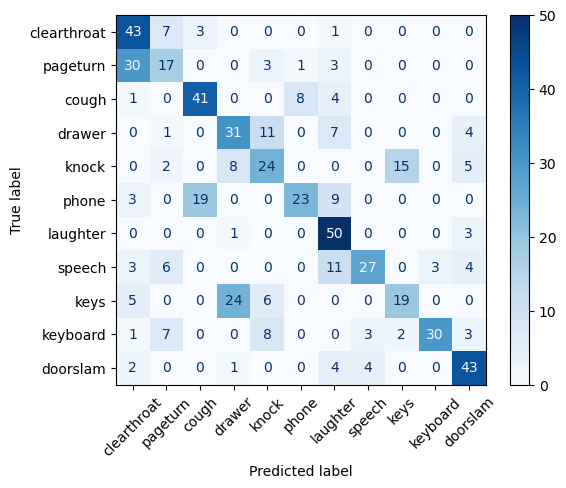

In [86]:
y_pred, y_true = [], []
for logmels, labels in test_loader:
    y_pred.append(clf(logmels).argmax(dim=1).detach().cpu().numpy())
    y_true.append(labels.detach().cpu().numpy())
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, 
                                        display_labels=data.categories, 
                                        xticks_rotation=45, cmap=plt.cm.Blues);

In [87]:
classification_rep = classification_report(y_true, y_pred, target_names=data.categories)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

 clearthroat       0.49      0.80      0.61        54
    pageturn       0.42      0.31      0.36        54
       cough       0.65      0.76      0.70        54
      drawer       0.48      0.57      0.52        54
       knock       0.46      0.44      0.45        54
       phone       0.72      0.43      0.53        54
    laughter       0.56      0.93      0.70        54
      speech       0.79      0.50      0.61        54
        keys       0.53      0.35      0.42        54
    keyboard       0.91      0.56      0.69        54
    doorslam       0.69      0.80      0.74        54

    accuracy                           0.59       594
   macro avg       0.61      0.59      0.58       594
weighted avg       0.61      0.59      0.58       594



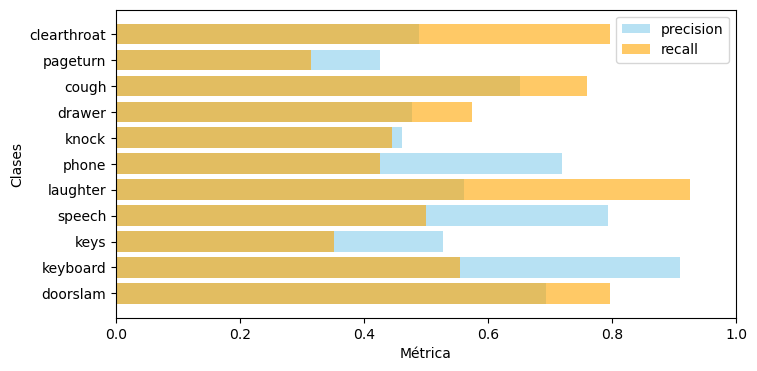

In [88]:
classification_rep = classification_report(y_true, y_pred, target_names=data.categories, output_dict=True)

precision_values = [classification_rep[label]['precision'] for label in classification_rep.keys() if label in data.categories]
recall_values = [classification_rep[label]['recall'] for label in classification_rep.keys() if label in data.categories]

class_labels = [label for label in classification_rep.keys() if label in data.categories]

plt.figure(figsize=(8, 4))
plt.barh(class_labels, precision_values, color='skyblue',label='precision',alpha =0.6)
plt.barh(class_labels, recall_values, color='orange',label='recall',alpha =0.6 )
plt.xlabel('Métrica')
plt.ylabel('Clases')

plt.xlim(0, 1) 
plt.gca().invert_yaxis()  
plt.legend()
plt.show()

## Modelo Acoplado (Aislado + Mixto)

In [89]:
clf = MyConvModel(params['training']).load_from_checkpoint('logs/lightning_logs/modelo_acoplado/checkpoints/best_model.ckpt')
clf.eval()

MyConvModel(
  (criterion): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.5, inplace=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.5, inplace=False)
    (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.5, inplace=False)
  )
  (c

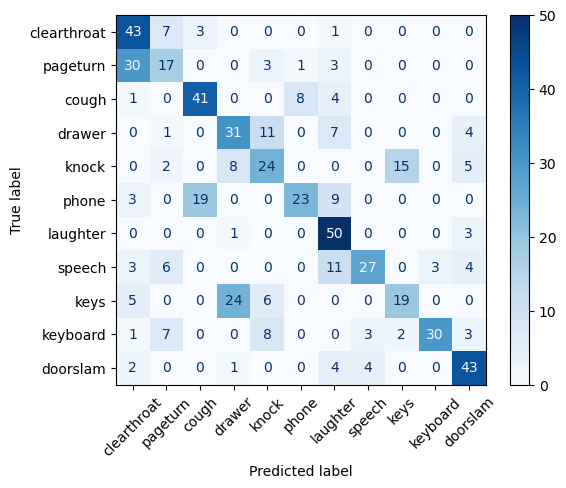

In [90]:

y_pred, y_true = [], []
for logmels, labels in test_loader:
    y_pred.append(clf(logmels).argmax(dim=1).detach().cpu().numpy())
    y_true.append(labels.detach().cpu().numpy())
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred, 
                                        display_labels=data.categories, 
                                        xticks_rotation=45, cmap=plt.cm.Blues);

In [91]:
classification_rep = classification_report(y_true, y_pred, target_names=data.categories)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

 clearthroat       0.49      0.80      0.61        54
    pageturn       0.42      0.31      0.36        54
       cough       0.65      0.76      0.70        54
      drawer       0.48      0.57      0.52        54
       knock       0.46      0.44      0.45        54
       phone       0.72      0.43      0.53        54
    laughter       0.56      0.93      0.70        54
      speech       0.79      0.50      0.61        54
        keys       0.53      0.35      0.42        54
    keyboard       0.91      0.56      0.69        54
    doorslam       0.69      0.80      0.74        54

    accuracy                           0.59       594
   macro avg       0.61      0.59      0.58       594
weighted avg       0.61      0.59      0.58       594



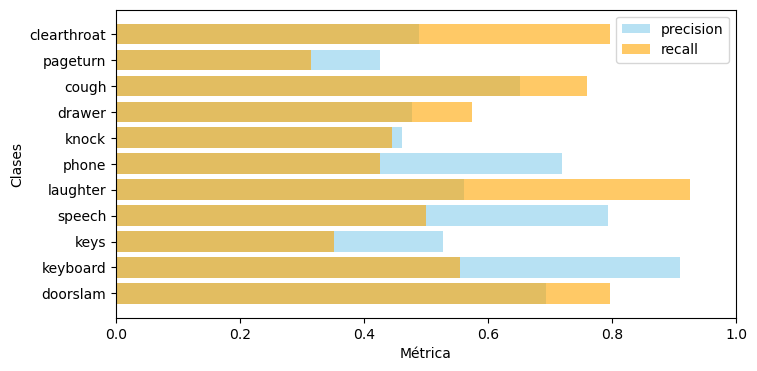

In [92]:
classification_rep = classification_report(y_true, y_pred, target_names=data.categories, output_dict=True)

precision_values = [classification_rep[label]['precision'] for label in classification_rep.keys() if label in data.categories]
recall_values = [classification_rep[label]['recall'] for label in classification_rep.keys() if label in data.categories]

class_labels = [label for label in classification_rep.keys() if label in data.categories]

plt.figure(figsize=(8, 4))
plt.barh(class_labels, precision_values, color='skyblue',label='precision',alpha =0.6)
plt.barh(class_labels, recall_values, color='orange',label='recall',alpha =0.6 )
plt.xlabel('Métrica')
plt.ylabel('Clases')

plt.xlim(0, 1) 
plt.gca().invert_yaxis()  
plt.legend()
plt.show()